In [1]:
import numpy as np

In [2]:
from pathlib import Path
import sys

repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from DNN.utils import (
    Layer_Dense,
    Activation_ReLU,
    Activation_Softmax,
    Loss_CategoricalCrossentropy,
    Optimizer_SGD,
    Optimizer_Adam,
    Activation_Softmax_Loss_CategoricalCrossentropy,
 )

In [3]:
class Layer_Conv2D:
    """
    2D Convolution layer (NCHW).
    - inputs:  (N, C_in, H, W)
    - weights: (C_out, C_in, K, K)
    - biases:  (1, C_out)
    - output:  (N, C_out, H_out, W_out)
    """

    def __init__(self, n_input_channels, n_filters, filter_size,
                 stride=1, padding=0,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):

        self.n_input_channels = n_input_channels
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.stride = stride
        self.padding = padding

        # Heuristic small init (same idea as your Dense layer)
        self.weights = 0.01 * np.random.randn(n_filters, n_input_channels,
                                              filter_size, filter_size)
        self.biases = np.zeros((1, n_filters))

        # Regularization
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def _pad_inputs(self, inputs):
        if self.padding <= 0:
            return inputs
        pad = self.padding
        return np.pad(inputs,
                      pad_width=((0, 0), (0, 0), (pad, pad), (pad, pad)),
                      mode='constant',
                      constant_values=0)

    def forward(self, inputs):
        # Store for backward
        self.inputs = inputs

        N, C_in, H, W = inputs.shape
        K = self.filter_size
        S = self.stride
        P = self.padding

        assert C_in == self.n_input_channels, \
            f"Expected C_in={self.n_input_channels}, got {C_in}"

        # Pad
        inputs_padded = self._pad_inputs(inputs)
        self.inputs_padded = inputs_padded  # store for backward

        H_p, W_p = inputs_padded.shape[2], inputs_padded.shape[3]

        # Output sizes
        H_out = (H_p - K) // S + 1
        W_out = (W_p - K) // S + 1

        # Compute convolution (loop-based for clarity)
        output = np.zeros((N, self.n_filters, H_out, W_out), dtype=inputs.dtype)

        for n in range(N):
            for f in range(self.n_filters):
                for i in range(H_out):
                    h_start = i * S
                    h_end = h_start + K
                    for j in range(W_out):
                        w_start = j * S
                        w_end = w_start + K

                        window = inputs_padded[n, :, h_start:h_end, w_start:w_end]
                        output[n, f, i, j] = np.sum(window * self.weights[f]) + self.biases[0, f]

        self.output = output

    def backward(self, dvalues):
        """
        dvalues: (N, C_out, H_out, W_out)
        """
        N, C_in, H, W = self.inputs.shape
        K = self.filter_size
        S = self.stride
        P = self.padding

        _, C_out, H_out, W_out = dvalues.shape
        assert C_out == self.n_filters, \
            f"Expected C_out={self.n_filters}, got {C_out}"

        # Init grads
        self.dweights = np.zeros_like(self.weights)
        self.dbiases = np.zeros_like(self.biases)

        dinputs_padded = np.zeros_like(self.inputs_padded)

        # Bias gradient: sum over N,H_out,W_out
        self.dbiases[0, :] = np.sum(dvalues, axis=(0, 2, 3))

        # Weight + input gradients
        for n in range(N):
            for f in range(self.n_filters):
                for i in range(H_out):
                    h_start = i * S
                    h_end = h_start + K
                    for j in range(W_out):
                        w_start = j * S
                        w_end = w_start + K

                        grad = dvalues[n, f, i, j]
                        window = self.inputs_padded[n, :, h_start:h_end, w_start:w_end]

                        # dW accumulates window * upstream_grad
                        self.dweights[f] += window * grad

                        # dX accumulates W * upstream_grad
                        dinputs_padded[n, :, h_start:h_end, w_start:w_end] += self.weights[f] * grad

        # Regularization gradients (same style as your Dense)
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights

        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

        # Unpad dinputs
        if P > 0:
            self.dinputs = dinputs_padded[:, :, P:P+H, P:P+W]
        else:
            self.dinputs = dinputs_padded


# ---------- quick sanity checks ----------
if __name__ == "__main__":
    np.random.seed(0)

    X = np.random.randn(2, 3, 5, 5).astype(np.float32)
    conv = Layer_Conv2D(n_input_channels=3, n_filters=4, filter_size=3, stride=1, padding=1)

    conv.forward(X)
    print("Forward output shape:", conv.output.shape)  # expected (2, 4, 5, 5)

    dOut = np.random.randn(*conv.output.shape).astype(np.float32)
    conv.backward(dOut)
    print("dinputs shape:", conv.dinputs.shape)        # expected (2, 3, 5, 5)
    print("dweights shape:", conv.dweights.shape)      # expected (4, 3, 3, 3)
    print("dbiases shape:", conv.dbiases.shape)        # expected (1, 4)

    # Optional: numeric gradient check for ONE weight element
    def numeric_grad_one_weight(layer, X, dOut, f=0, c=0, kh=0, kw=0, eps=1e-5):
        orig = layer.weights[f, c, kh, kw]

        layer.weights[f, c, kh, kw] = orig + eps
        layer.forward(X)
        loss_pos = np.sum(layer.output * dOut)

        layer.weights[f, c, kh, kw] = orig - eps
        layer.forward(X)
        loss_neg = np.sum(layer.output * dOut)

        layer.weights[f, c, kh, kw] = orig
        return (loss_pos - loss_neg) / (2 * eps)

    conv.forward(X)
    conv.backward(dOut)
    g_num = numeric_grad_one_weight(conv, X, dOut, f=0, c=0, kh=1, kw=1)
    g_ana = conv.dweights[0, 0, 1, 1]
    print("grad check (one weight) numeric:", g_num, "analytic:", g_ana, "abs diff:", abs(g_num - g_ana))


Forward output shape: (2, 4, 5, 5)
dinputs shape: (2, 3, 5, 5)
dweights shape: (4, 3, 3, 3)
dbiases shape: (1, 4)
grad check (one weight) numeric: -8.091331 analytic: -8.091152 abs diff: 0.0001783371


In [4]:
class Layer_MaxPool2D:
    """
    MaxPool2D (NCHW).
    - inputs:  (N, C, H, W)
    - output:  (N, C, H_out, W_out)
    """

    def __init__(self, pool_size=2, stride=None):
        self.pool_size = pool_size
        self.stride = stride if stride is not None else pool_size

    def forward(self, inputs):
        self.inputs = inputs
        N, C, H, W = inputs.shape
        P = self.pool_size
        S = self.stride

        H_out = (H - P) // S + 1
        W_out = (W - P) // S + 1

        output = np.zeros((N, C, H_out, W_out), dtype=inputs.dtype)

        # Store argmax positions for backward
        # We'll store (h_offset, w_offset) inside the pooling window
        self.argmax_h = np.zeros((N, C, H_out, W_out), dtype=np.int32)
        self.argmax_w = np.zeros((N, C, H_out, W_out), dtype=np.int32)

        for n in range(N):
            for c in range(C):
                for i in range(H_out):
                    h_start = i * S
                    h_end = h_start + P
                    for j in range(W_out):
                        w_start = j * S
                        w_end = w_start + P

                        window = inputs[n, c, h_start:h_end, w_start:w_end]
                        idx = np.argmax(window)  # flattened index
                        ih, iw = np.unravel_index(idx, window.shape)

                        output[n, c, i, j] = window[ih, iw]
                        self.argmax_h[n, c, i, j] = ih
                        self.argmax_w[n, c, i, j] = iw

        self.output = output

    def backward(self, dvalues):
        N, C, H, W = self.inputs.shape
        P = self.pool_size
        S = self.stride
        _, _, H_out, W_out = dvalues.shape

        self.dinputs = np.zeros_like(self.inputs)

        for n in range(N):
            for c in range(C):
                for i in range(H_out):
                    h_start = i * S
                    for j in range(W_out):
                        w_start = j * S

                        ih = self.argmax_h[n, c, i, j]
                        iw = self.argmax_w[n, c, i, j]

                        self.dinputs[n, c, h_start + ih, w_start + iw] += dvalues[n, c, i, j]


In [5]:
class Layer_Flatten:
    """
    Flatten: (N, C, H, W) -> (N, C*H*W)
    """
    def forward(self, inputs):
        self.inputs_shape = inputs.shape
        self.output = inputs.reshape(inputs.shape[0], -1)

    def backward(self, dvalues):
        self.dinputs = dvalues.reshape(self.inputs_shape)


In [6]:
if __name__ == "__main__":
    np.random.seed(0)

    # Fake "MNIST-like" batch: N=4, C=1, H=W=28
    X = np.random.randn(4, 1, 28, 28).astype(np.float32)

    conv = Layer_Conv2D(n_input_channels=1, n_filters=8, filter_size=3, stride=1, padding=1)
    relu = Activation_ReLU()
    pool = Layer_MaxPool2D(pool_size=2, stride=2)
    flat = Layer_Flatten()
    dense = Layer_Dense(8 * 14 * 14, 10)

    # Forward
    conv.forward(X)
    relu.forward(conv.output)
    pool.forward(relu.output)
    flat.forward(pool.output)
    dense.forward(flat.output)

    print("conv:", conv.output.shape)   # (4, 8, 28, 28)
    print("pool:", pool.output.shape)   # (4, 8, 14, 14)
    print("flat:", flat.output.shape)   # (4, 8*14*14)
    print("dense:", dense.output.shape) # (4, 10)

    # Backward (fake upstream gradient)
    dDense = np.random.randn(*dense.output.shape).astype(np.float32)
    dense.backward(dDense)
    flat.backward(dense.dinputs)
    pool.backward(flat.dinputs)
    relu.backward(pool.dinputs)
    conv.backward(relu.dinputs)

    print("dX:", conv.dinputs.shape)    # (4, 1, 28, 28)


conv: (4, 8, 28, 28)
pool: (4, 8, 14, 14)
flat: (4, 1568)
dense: (4, 10)
dX: (4, 1, 28, 28)


In [7]:
import os
import struct

def load_idx_images(path):
    with open(path, "rb") as f:
        magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
        assert magic == 2051, f"Bad magic for images: {magic}"
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(n, rows, cols)

def load_idx_labels(path):
    with open(path, "rb") as f:
        magic, n = struct.unpack(">II", f.read(8))
        assert magic == 2049, f"Bad magic for labels: {magic}"
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(n)

def _resolve_mnist_file(data_dir, candidates):
    for name in candidates:
        path = os.path.join(data_dir, name)
        if os.path.isfile(path):
            return path
    raise FileNotFoundError(
        f"MNIST file not found. Looked for: {candidates}. "
        "Run download_mnist(data_dir) if needed."
    )

def load_mnist(data_dir="data/mnist"):
    # download_mnist(data_dir)
    train_images_path = _resolve_mnist_file(
        data_dir, ["train-images-idx3-ubyte", "train-images.idx3-ubyte"]
    )
    train_labels_path = _resolve_mnist_file(
        data_dir, ["train-labels-idx1-ubyte", "train-labels.idx1-ubyte"]
    )
    test_images_path = _resolve_mnist_file(
        data_dir, ["t10k-images-idx3-ubyte", "t10k-images.idx3-ubyte"]
    )
    test_labels_path = _resolve_mnist_file(
        data_dir, ["t10k-labels-idx1-ubyte", "t10k-labels.idx1-ubyte"]
    )
    train_images = load_idx_images(train_images_path)
    train_labels = load_idx_labels(train_labels_path)
    test_images  = load_idx_images(test_images_path)
    test_labels  = load_idx_labels(test_labels_path)
    return train_images, train_labels, test_images, test_labels

def preprocess_mnist(images, labels):
    # images: (N, 28, 28) uint8 -> (N, 1, 28, 28) float32 in [0,1]
    X = images.astype(np.float32) / 255.0
    X = X[:, None, :, :]  # add channel dim -> NCHW
    y = labels.astype(np.int64)
    return X, y


In [8]:
import numpy as np

def accuracy_from_probs(probs, y_true):
    preds = np.argmax(probs, axis=1)
    return np.mean(preds == y_true)

def iterate_minibatches(X, y, batch_size, shuffle=True):
    N = X.shape[0]
    idx = np.arange(N)
    if shuffle:
        np.random.shuffle(idx)
    for start in range(0, N, batch_size):
        batch_idx = idx[start:start + batch_size]
        yield X[batch_idx], y[batch_idx]

if __name__ == "__main__":
    # ---- load MNIST ----
    train_images, train_labels, test_images, test_labels = load_mnist("data/mnist")
    X_train, y_train = preprocess_mnist(train_images, train_labels)
    X_test,  y_test  = preprocess_mnist(test_images, test_labels)

    # ---- IMPORTANT: start small (because loop-based conv is slow) ----
    # After correctness is proven, increase these.
    n_train_small = 10000
    n_test_small  = 2000
    X_train, y_train = X_train[:n_train_small], y_train[:n_train_small]
    X_test, y_test   = X_test[:n_test_small], y_test[:n_test_small]

    # ---- model: Conv -> ReLU -> Pool -> Conv -> ReLU -> Pool -> Flatten -> Dense -> ReLU -> Dense -> Softmax+CE ----
    conv1 = Layer_Conv2D(n_input_channels=1, n_filters=8, filter_size=3, stride=1, padding=1)
    relu1 = Activation_ReLU()
    pool1 = Layer_MaxPool2D(pool_size=2, stride=2)

    conv2 = Layer_Conv2D(n_input_channels=8, n_filters=16, filter_size=3, stride=1, padding=1)
    relu2 = Activation_ReLU()
    pool2 = Layer_MaxPool2D(pool_size=2, stride=2)

    flat = Layer_Flatten()
    dense1 = Layer_Dense(16 * 7 * 7, 128)
    relu3 = Activation_ReLU()
    dense2 = Layer_Dense(128, 10)

    loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

    optimizer = Optimizer_Adam(learning_rate=0.001, decay=0.0)

    # ---- training ----
    epochs = 3
    batch_size = 64

    for epoch in range(1, epochs + 1):
        losses = []
        accs = []
        total_batches = (X_train.shape[0] + batch_size - 1) // batch_size

        for batch_i, (Xb, yb) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=True), start=1):
            # Forward
            conv1.forward(Xb)
            relu1.forward(conv1.output)
            pool1.forward(relu1.output)

            conv2.forward(pool1.output)
            relu2.forward(conv2.output)
            pool2.forward(relu2.output)

            flat.forward(pool2.output)
            dense1.forward(flat.output)
            relu3.forward(dense1.output)
            dense2.forward(relu3.output)

            loss = loss_activation.forward(dense2.output, yb)
            acc = accuracy_from_probs(loss_activation.output, yb)

            losses.append(loss)
            accs.append(acc)

            # Backward
            loss_activation.backward(loss_activation.output, yb)
            dense2.backward(loss_activation.dinputs)
            relu3.backward(dense2.dinputs)
            dense1.backward(relu3.dinputs)
            flat.backward(dense1.dinputs)
            pool2.backward(flat.dinputs)
            relu2.backward(pool2.dinputs)
            conv2.backward(relu2.dinputs)
            pool1.backward(conv2.dinputs)
            relu1.backward(pool1.dinputs)
            conv1.backward(relu1.dinputs)

            # Update
            optimizer.pre_update_params()
            optimizer.update_params(conv1)
            optimizer.update_params(conv2)
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)
            optimizer.post_update_params()

            if batch_i % 100 == 0 or batch_i == total_batches:
                print(
                    f"epoch {epoch}/{epochs} | batch {batch_i}/{total_batches} | "
                    f"loss {np.mean(losses):.4f} | acc {np.mean(accs):.4f}"
                )

        # ---- evaluate on test subset ----
        conv1.forward(X_test); relu1.forward(conv1.output); pool1.forward(relu1.output)
        conv2.forward(pool1.output); relu2.forward(conv2.output); pool2.forward(relu2.output)
        flat.forward(pool2.output); dense1.forward(flat.output); relu3.forward(dense1.output); dense2.forward(relu3.output)
        test_loss = loss_activation.forward(dense2.output, y_test)
        test_acc = accuracy_from_probs(loss_activation.output, y_test)

        print(
            f"epoch {epoch}/{epochs} | "
            f"train_loss {np.mean(losses):.4f} | train_acc {np.mean(accs):.4f} | "
            f"test_loss {test_loss:.4f} | test_acc {test_acc:.4f}"
        )


epoch 1/3 | batch 100/157 | loss 1.5223 | acc 0.4888
epoch 1/3 | batch 157/157 | loss 1.1740 | acc 0.6070
epoch 1/3 | train_loss 1.1740 | train_acc 0.6070 | test_loss 0.6544 | test_acc 0.7820
epoch 2/3 | batch 100/157 | loss 0.4401 | acc 0.8617
epoch 2/3 | batch 157/157 | loss 0.4094 | acc 0.8731
epoch 2/3 | train_loss 0.4094 | train_acc 0.8731 | test_loss 0.4144 | test_acc 0.8665
epoch 3/3 | batch 100/157 | loss 0.3097 | acc 0.9066
epoch 3/3 | batch 157/157 | loss 0.2981 | acc 0.9094
epoch 3/3 | train_loss 0.2981 | train_acc 0.9094 | test_loss 0.3118 | test_acc 0.9015


In [9]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

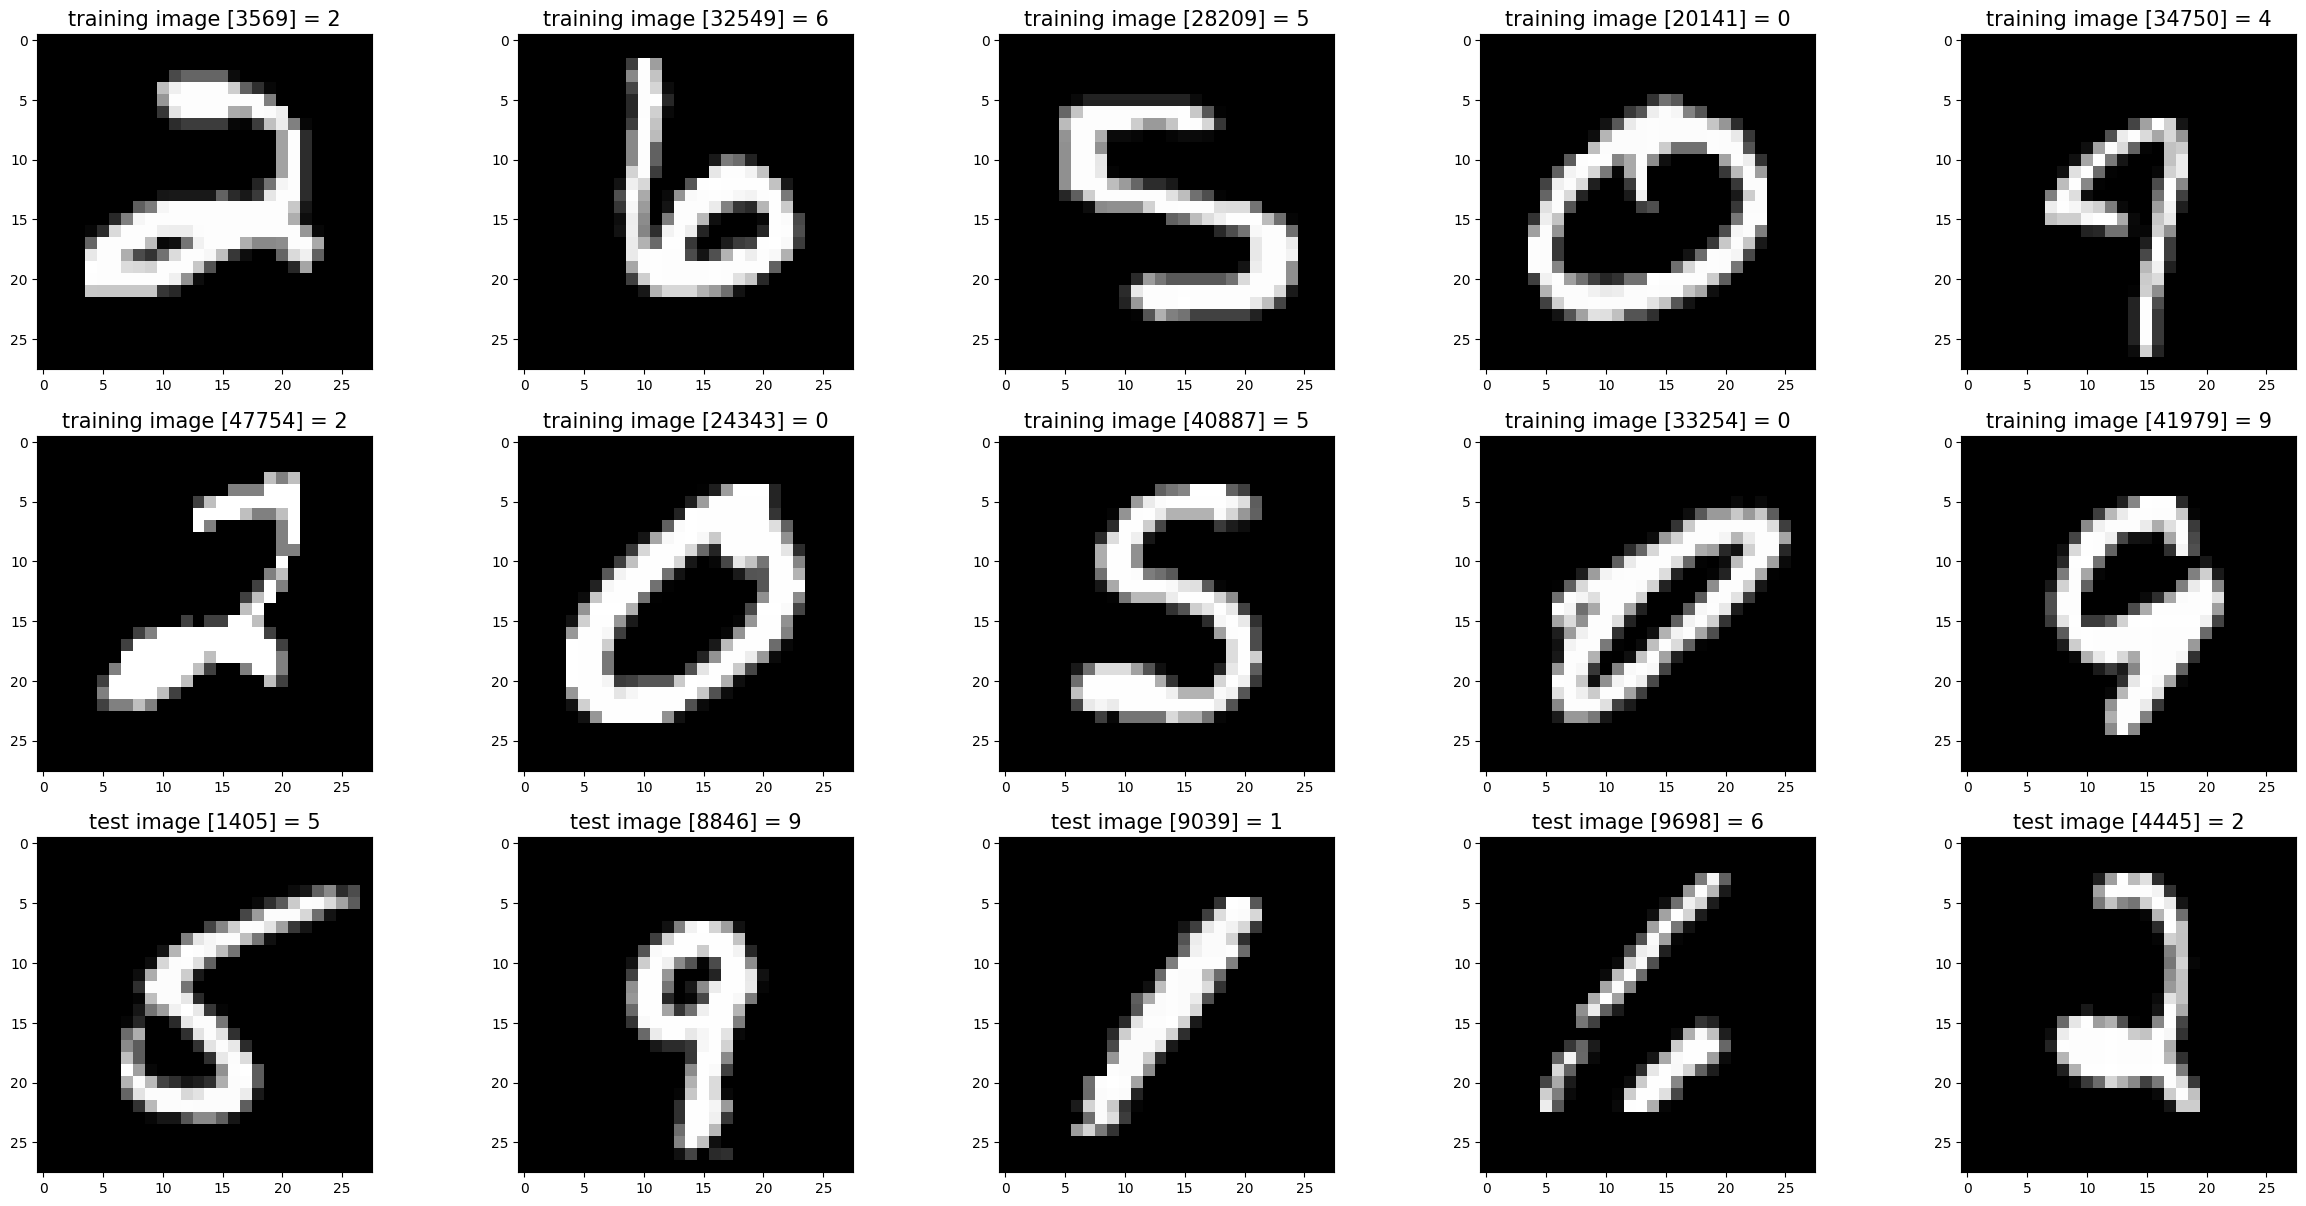

In [11]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt
from os.path import join

#
# Set file paths based on added MNIST Datasets
#
input_path = 'data/mnist'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

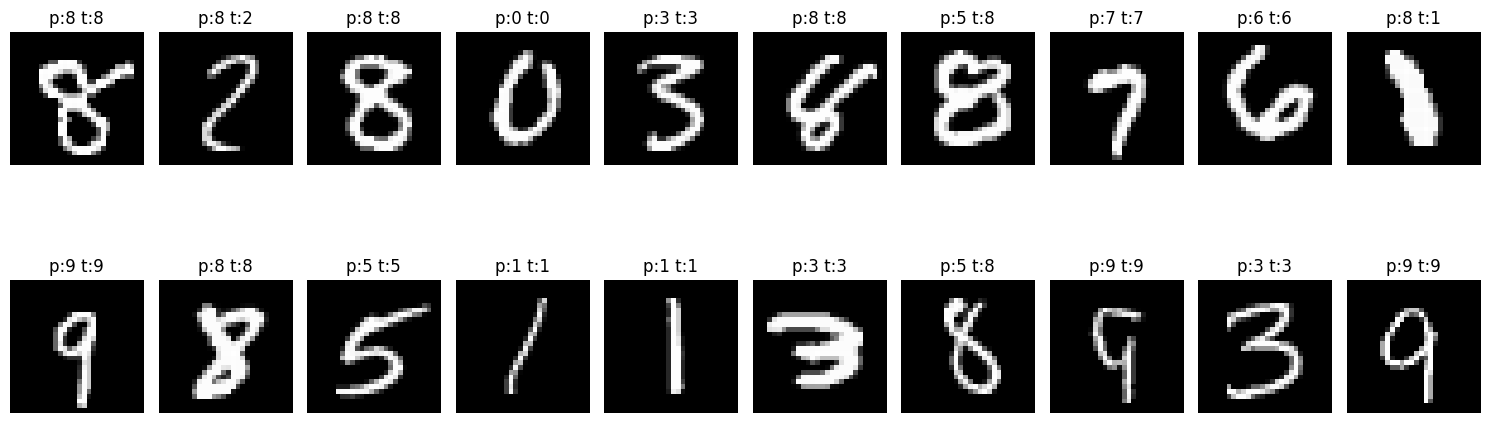

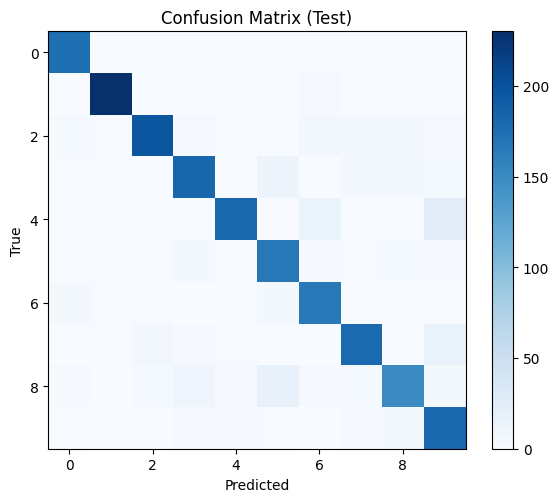

In [14]:
import numpy as np
import matplotlib.pyplot as plt

required = [
    "X_train", "y_train", "X_test", "y_test",
    "conv1", "relu1", "pool1", "conv2", "relu2", "pool2",
    "flat", "dense1", "relu3", "dense2"
 ]
missing = [name for name in required if name not in globals()]
if missing:
    print("Missing variables for visualization:", missing)
else:
    X_test_np = np.asarray(X_test)
    y_test_np = np.asarray(y_test)

    def forward_pass(Xb):
        conv1.forward(Xb)
        relu1.forward(conv1.output)
        pool1.forward(relu1.output)
        conv2.forward(pool1.output)
        relu2.forward(conv2.output)
        pool2.forward(relu2.output)
        flat.forward(pool2.output)
        dense1.forward(flat.output)
        relu3.forward(dense1.output)
        dense2.forward(relu3.output)
        return dense2.output

    # ---- visualize a grid of test predictions ----
    n_show = 20
    idx = np.random.choice(len(X_test_np), n_show, replace=False)
    cols = 10
    rows = int(np.ceil(n_show / cols))
    plt.figure(figsize=(15, 3 * rows))
    for i, sample_idx in enumerate(idx, start=1):
        x = X_test_np[sample_idx:sample_idx + 1]
        logits = forward_pass(x)
        pred = int(np.argmax(logits, axis=1)[0])
        true = int(y_test_np[sample_idx])
        plt.subplot(rows, cols, i)
        plt.imshow(X_test_np[sample_idx, 0], cmap="gray")
        plt.axis("off")
        plt.title(f"p:{pred} t:{true}")
    plt.tight_layout()
    plt.show()

    # ---- confusion matrix on test set ----
    y_pred = []
    for Xb, _ in iterate_minibatches(X_test_np, y_test_np, batch_size=256, shuffle=False):
        logits = forward_pass(Xb)
        y_pred.append(np.argmax(logits, axis=1))
    y_pred = np.concatenate(y_pred)

    cm = np.zeros((10, 10), dtype=np.int64)
    for t, p in zip(y_test_np, y_pred):
        cm[int(t), int(p)] += 1

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
